In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import yfinance as yf
from datetime import datetime,timedelta
warnings.filterwarnings('ignore')

In [ ]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500 = pd.read_html(url)[0]

In [ ]:
sp500_metadata = sp500[['Symbol', 'Company', 'GICS Sector']]
sp500_metadata.columns = ['Ticker', 'Company Name', 'Sector']

In [ ]:
sp500_metadata.head()

,Ticker,Company Name,Sector
0,MMM,3M,Industrials
1,AOS,A. O. Smith,Industrials
2,ABT,Abbott Laboratories,Health Care
3,ABBV,AbbVie,Health Care
4,ACN,Accenture,Information Technology


In [ ]:
sp500_tickers = sp500_metadata['Ticker'].tolist()

In [ ]:
end_date = datetime.today().strftime("%Y-%m-%d")
start_date = (datetime.today() - timedelta(days=10 * 365)).strftime("%Y-%m-%d")

In [ ]:
print(f"Fetching data from {start_date} to {end_date}")

Fetching data from 2014-12-11 to 2024-12-08


In [ ]:
sp500_data = yf.download(sp500_tickers, start=start_date, end=end_date, group_by="ticker")

[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2014-12-11 -> 2024-12-08)')
ERROR:yfinance:['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


In [ ]:
def fetch_ratios(ticker):
    try:
        stock = yf.Ticker(ticker)
        balance_sheet = stock.balance_sheet
        income_statement = stock.financials
        stock_info = stock.info  # Use the info dictionary for additional data
        stock_history = stock.history(period="1d")
        stock_price = stock_history["Close"].iloc[-1] if not stock_history.empty else None

        # Helper function to safely extract values from DataFrame
        def safe_get_value(df, row_name):
            if df is not None and not df.empty and row_name in df.index:
                return df.loc[row_name].values[0]
            return None

        # Retrieve values safely
        debt = safe_get_value(balance_sheet, "Total Liabilities Net Minority Interest")
        equity = safe_get_value(balance_sheet, "Stockholders Equity")
        interest_expense = safe_get_value(income_statement, "Interest Expense")
        ebit = safe_get_value(income_statement, "EBIT")
        total_assets = safe_get_value(balance_sheet, "Total Assets")
        revenue = safe_get_value(income_statement, "Total Revenue")
        net_income = safe_get_value(income_statement, "Net Income")
        shares_outstanding = stock_info.get("sharesOutstanding", None)

        # Calculate Ratios with Validity Checks
        debt_equity_ratio = (debt / equity) if debt is not None and equity is not None and equity != 0 else None
        interest_coverage = (ebit / interest_expense) if ebit is not None and interest_expense is not None and interest_expense != 0 else None
        asset_turnover_ratio = (revenue / total_assets) if revenue is not None and total_assets is not None and total_assets != 0 else None
        eps = (net_income / shares_outstanding) if net_income is not None and shares_outstanding is not None else None
        pe_ratio = (stock_price / eps) if stock_price is not None and eps is not None and eps != 0 else None
        roe = (net_income / equity) if net_income is not None and equity is not None and equity != 0 else None

        return {
            "Debt Equity Ratio": debt_equity_ratio,
            "Interest Coverage Ratio": interest_coverage,
            "Asset Turnover Ratio": asset_turnover_ratio,
            "Earnings Per Share (EPS)": eps,
            "Price-to-Earnings (P/E) Ratio": pe_ratio,
            "Return on Equity (ROE)": roe
        }

    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return {
            "Debt Equity Ratio": None,
            "Interest Coverage Ratio": None,
            "Asset Turnover Ratio": None,
            "Earnings Per Share (EPS)": None,
            "Price-to-Earnings (P/E) Ratio": None,
            "Return on Equity (ROE)": None
        }


In [ ]:
data_list = []

In [ ]:
from tqdm import tqdm

data_list = []

# Iterate over the tickers with a progress bar
for ticker in tqdm(sp500_tickers, desc="Processing SP500 Tickers"):
    if ticker in sp500_data.columns.levels[0]:  # Check if ticker data exists
        ticker_data = sp500_data[ticker].copy()

        # Add metadata (Company Name and Sector)
        ticker_data['Ticker'] = ticker
        ticker_data['Company Name'] = sp500_metadata.loc[sp500_metadata['Ticker'] == ticker, 'Company Name'].values[0]
        ticker_data['Sector'] = sp500_metadata.loc[sp500_metadata['Ticker'] == ticker, 'Sector'].values[0]

        # Fetch financial ratios
        ratios = fetch_ratios(ticker)
        ticker_data['Debt Equity Ratio'] = ratios["Debt Equity Ratio"]
        ticker_data['Interest Coverage Ratio'] = ratios["Interest Coverage Ratio"]
        ticker_data['Asset Turnover Ratio'] = ratios["Asset Turnover Ratio"]
        ticker_data['EPS'] = ratios["Earnings Per Share (EPS)"]
        ticker_data['P/E Ratio'] = ratios["Price-to-Earnings (P/E) Ratio"]
        ticker_data['ROE'] = ratios["Return on Equity (ROE)"]

        data_list.append(ticker_data)


Processing SP500 Tickers:  79%|███████▊  | 395/503 [03:37<02:32,  1.42s/it]

Error fetching data for RTX: Expecting value: line 1 column 1 (char 0)


ERROR:yfinance:429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/O?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=O&crumb=Edge%3A+Too+Many+Requests
Processing SP500 Tickers:  79%|███████▊  | 396/503 [03:41<03:57,  2.22s/it]

Error fetching data for O: Expecting value: line 1 column 1 (char 0)


ERROR:yfinance:429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/REG?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=REG&crumb=Edge%3A+Too+Many+Requests
Processing SP500 Tickers:  79%|███████▉  | 397/503 [03:45<04:37,  2.62s/it]

Error fetching data for REG: Expecting value: line 1 column 1 (char 0)


ERROR:yfinance:429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/REGN?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=REGN&crumb=Edge%3A+Too+Many+Requests
Processing SP500 Tickers:  79%|███████▉  | 398/503 [03:48<04:37,  2.64s/it]

Error fetching data for REGN: Expecting value: line 1 column 1 (char 0)


ERROR:yfinance:429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RF?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RF&crumb=Edge%3A+Too+Many+Requests
Processing SP500 Tickers:  79%|███████▉  | 399/503 [03:50<04:41,  2.71s/it]

Error fetching data for RF: Expecting value: line 1 column 1 (char 0)


ERROR:yfinance:429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RSG?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RSG&crumb=Edge%3A+Too+Many+Requests
Processing SP500 Tickers:  80%|███████▉  | 400/503 [03:54<04:49,  2.81s/it]

Error fetching data for RSG: Expecting value: line 1 column 1 (char 0)


ERROR:yfinance:429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RMD?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RMD&crumb=Edge%3A+Too+Many+Requests
Processing SP500 Tickers:  80%|███████▉  | 401/503 [03:56<04:51,  2.85s/it]

Error fetching data for RMD: Expecting value: line 1 column 1 (char 0)


ERROR:yfinance:429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RVTY?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RVTY&crumb=Edge%3A+Too+Many+Requests
Processing SP500 Tickers:  80%|███████▉  | 402/503 [03:59<04:40,  2.78s/it]

Error fetching data for RVTY: Expecting value: line 1 column 1 (char 0)


ERROR:yfinance:429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ROK?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ROK&crumb=Edge%3A+Too+Many+Requests
Processing SP500 Tickers:  80%|████████  | 403/503 [04:02<04:40,  2.81s/it]

Error fetching data for ROK: Expecting value: line 1 column 1 (char 0)


ERROR:yfinance:429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ROL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ROL&crumb=Edge%3A+Too+Many+Requests
Processing SP500 Tickers:  80%|████████  | 404/503 [04:05<04:52,  2.96s/it]

Error fetching data for ROL: Expecting value: line 1 column 1 (char 0)


ERROR:yfinance:429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ROP?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ROP&crumb=Edge%3A+Too+Many+Requests
Processing SP500 Tickers:  81%|████████  | 405/503 [04:08<04:43,  2.90s/it]

Error fetching data for ROP: Expecting value: line 1 column 1 (char 0)


ERROR:yfinance:429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ROST?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ROST&crumb=Edge%3A+Too+Many+Requests
Processing SP500 Tickers:  81%|████████  | 406/503 [04:11<04:47,  2.96s/it]

Error fetching data for ROST: Expecting value: line 1 column 1 (char 0)


ERROR:yfinance:429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RCL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RCL&crumb=Edge%3A+Too+Many+Requests
Processing SP500 Tickers:  81%|████████  | 407/503 [04:14<04:36,  2.88s/it]

Error fetching data for RCL: Expecting value: line 1 column 1 (char 0)


ERROR:yfinance:429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SPGI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SPGI&crumb=Edge%3A+Too+Many+Requests
Processing SP500 Tickers:  81%|████████  | 408/503 [04:17<04:37,  2.92s/it]

Error fetching data for SPGI: Expecting value: line 1 column 1 (char 0)


ERROR:yfinance:429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CRM?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CRM&crumb=Edge%3A+Too+Many+Requests
Processing SP500 Tickers:  81%|████████▏ | 409/503 [04:20<04:35,  2.93s/it]

Error fetching data for CRM: Expecting value: line 1 column 1 (char 0)


ERROR:yfinance:429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SBAC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SBAC&crumb=Edge%3A+Too+Many+Requests
Processing SP500 Tickers:  82%|████████▏ | 410/503 [04:23<04:27,  2.88s/it]

Error fetching data for SBAC: Expecting value: line 1 column 1 (char 0)


ERROR:yfinance:429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SLB?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SLB&crumb=Edge%3A+Too+Many+Requests
Processing SP500 Tickers:  82%|████████▏ | 411/503 [04:26<04:30,  2.94s/it]

Error fetching data for SLB: Expecting value: line 1 column 1 (char 0)


ERROR:yfinance:429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/STX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=STX&crumb=Edge%3A+Too+Many+Requests
Processing SP500 Tickers:  82%|████████▏ | 412/503 [04:29<04:26,  2.93s/it]

Error fetching data for STX: Expecting value: line 1 column 1 (char 0)


ERROR:yfinance:429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SRE?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SRE&crumb=Edge%3A+Too+Many+Requests
Processing SP500 Tickers:  82%|████████▏ | 413/503 [04:31<04:19,  2.88s/it]

Error fetching data for SRE: Expecting value: line 1 column 1 (char 0)


ERROR:yfinance:429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NOW?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NOW&crumb=Edge%3A+Too+Many+Requests
Processing SP500 Tickers:  82%|████████▏ | 414/503 [04:34<04:23,  2.96s/it]

Error fetching data for NOW: Expecting value: line 1 column 1 (char 0)


ERROR:yfinance:429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SHW?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SHW&crumb=Edge%3A+Too+Many+Requests
Processing SP500 Tickers:  83%|████████▎ | 415/503 [04:37<04:18,  2.94s/it]

Error fetching data for SHW: Expecting value: line 1 column 1 (char 0)


ERROR:yfinance:429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SPG?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SPG&crumb=Edge%3A+Too+Many+Requests
Processing SP500 Tickers:  83%|████████▎ | 416/503 [04:40<04:10,  2.88s/it]

Error fetching data for SPG: Expecting value: line 1 column 1 (char 0)


ERROR:yfinance:429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SWKS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SWKS&crumb=Edge%3A+Too+Many+Requests
Processing SP500 Tickers:  83%|████████▎ | 417/503 [04:43<04:01,  2.81s/it]

Error fetching data for SWKS: Expecting value: line 1 column 1 (char 0)


ERROR:yfinance:429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SJM?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SJM&crumb=Edge%3A+Too+Many+Requests
Processing SP500 Tickers:  83%|████████▎ | 418/503 [04:46<04:06,  2.90s/it]

Error fetching data for SJM: Expecting value: line 1 column 1 (char 0)


ERROR:yfinance:429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SW?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SW&crumb=Edge%3A+Too+Many+Requests
Processing SP500 Tickers:  83%|████████▎ | 419/503 [04:49<03:59,  2.85s/it]

Error fetching data for SW: Expecting value: line 1 column 1 (char 0)


Processing SP500 Tickers:  83%|████████▎ | 420/503 [04:50<03:18,  2.39s/it]

Error fetching data for SNA: Expecting value: line 1 column 1 (char 0)


Processing SP500 Tickers:  84%|████████▎ | 421/503 [04:51<02:46,  2.03s/it]

Error fetching data for SOLV: Expecting value: line 1 column 1 (char 0)


Processing SP500 Tickers:  84%|████████▍ | 422/503 [04:53<02:29,  1.85s/it]

Error fetching data for SO: Expecting value: line 1 column 1 (char 0)


Processing SP500 Tickers:  84%|████████▍ | 423/503 [04:54<02:09,  1.62s/it]

Error fetching data for LUV: Expecting value: line 1 column 1 (char 0)


Processing SP500 Tickers:  84%|████████▍ | 424/503 [04:55<01:51,  1.42s/it]

Error fetching data for SWK: Expecting value: line 1 column 1 (char 0)


Processing SP500 Tickers:  84%|████████▍ | 425/503 [04:55<01:37,  1.25s/it]

Error fetching data for SBUX: Expecting value: line 1 column 1 (char 0)


Processing SP500 Tickers:  85%|████████▍ | 426/503 [04:56<01:31,  1.18s/it]

Error fetching data for STT: Expecting value: line 1 column 1 (char 0)


Processing SP500 Tickers:  85%|████████▍ | 427/503 [04:58<01:37,  1.28s/it]

Error fetching data for STLD: Expecting value: line 1 column 1 (char 0)


Processing SP500 Tickers:  85%|████████▌ | 428/503 [04:59<01:30,  1.21s/it]

Error fetching data for STE: Expecting value: line 1 column 1 (char 0)


Processing SP500 Tickers:  85%|████████▌ | 429/503 [05:00<01:22,  1.12s/it]

Error fetching data for SYK: Expecting value: line 1 column 1 (char 0)


Processing SP500 Tickers:  85%|████████▌ | 430/503 [05:01<01:20,  1.11s/it]

Error fetching data for SMCI: Expecting value: line 1 column 1 (char 0)


Processing SP500 Tickers:  86%|████████▌ | 431/503 [05:02<01:14,  1.04s/it]

Error fetching data for SYF: Expecting value: line 1 column 1 (char 0)


Processing SP500 Tickers:  86%|████████▌ | 432/503 [05:03<01:14,  1.04s/it]

Error fetching data for SNPS: Expecting value: line 1 column 1 (char 0)


Processing SP500 Tickers:  86%|████████▌ | 433/503 [05:04<01:18,  1.12s/it]

Error fetching data for SYY: Expecting value: line 1 column 1 (char 0)


Processing SP500 Tickers:  86%|████████▋ | 434/503 [05:05<01:15,  1.10s/it]

Error fetching data for TMUS: Expecting value: line 1 column 1 (char 0)


Processing SP500 Tickers:  86%|████████▋ | 435/503 [05:06<01:11,  1.04s/it]

Error fetching data for TROW: Expecting value: line 1 column 1 (char 0)


Processing SP500 Tickers:  87%|████████▋ | 436/503 [05:07<01:08,  1.02s/it]

Error fetching data for TTWO: Expecting value: line 1 column 1 (char 0)


Processing SP500 Tickers: 100%|██████████| 503/503 [05:41<00:00,  1.47it/s]


In [ ]:
sp500_data_combined = pd.concat(data_list)

In [ ]:
sp500_data_combined.to_csv("sp500_10_years_with_metadata_and_ratios.csv")

In [ ]:
sp500_data_combined.head()

Price,Open,High,Low,Close,Adj Close,Volume,Ticker,Company Name,Sector,Debt Equity Ratio,Interest Coverage Ratio,Asset Turnover Ratio,EPS,P/E Ratio,ROE
Date,,,,,,,,,,,,,,,
2014-12-11,133.093643,133.963211,132.458191,133.068558,94.992439,2915011.0,MMM,3M,Industrials,9.509465,-9.284501,0.646125,-12.845257,-10.36258,-1.45517
2014-12-12,132.575256,132.934784,131.371231,131.371231,93.780769,3373438.0,MMM,3M,Industrials,9.509465,-9.284501,0.646125,-12.845257,-10.36258,-1.45517
2014-12-15,132.207352,132.474915,130.091980,131.145493,93.619606,3120723.0,MMM,3M,Industrials,9.509465,-9.284501,0.646125,-12.845257,-10.36258,-1.45517
2014-12-16,131.488297,134.983276,131.337799,132.984955,94.932755,4043437.0,MMM,3M,Industrials,9.509465,-9.284501,0.646125,-12.845257,-10.36258,-1.45517
2014-12-17,133.185623,134.523407,131.923080,134.280930,95.857895,4715350.0,MMM,3M,Industrials,9.509465,-9.284501,0.646125,-12.845257,-10.36258,-1.45517


In [ ]:
sp500_df = sp500_data_combined

In [ ]:
sp500_df.head()

Price,Open,High,Low,Close,Adj Close,Volume,Ticker,Company Name,Sector,Debt Equity Ratio,Interest Coverage Ratio,Asset Turnover Ratio,EPS,P/E Ratio,ROE
Date,,,,,,,,,,,,,,,
2014-12-11,133.093643,133.963211,132.458191,133.068558,94.992439,2915011.0,MMM,3M,Industrials,9.509465,-9.284501,0.646125,-12.845257,-10.36258,-1.45517
2014-12-12,132.575256,132.934784,131.371231,131.371231,93.780769,3373438.0,MMM,3M,Industrials,9.509465,-9.284501,0.646125,-12.845257,-10.36258,-1.45517
2014-12-15,132.207352,132.474915,130.091980,131.145493,93.619606,3120723.0,MMM,3M,Industrials,9.509465,-9.284501,0.646125,-12.845257,-10.36258,-1.45517
2014-12-16,131.488297,134.983276,131.337799,132.984955,94.932755,4043437.0,MMM,3M,Industrials,9.509465,-9.284501,0.646125,-12.845257,-10.36258,-1.45517
2014-12-17,133.185623,134.523407,131.923080,134.280930,95.857895,4715350.0,MMM,3M,Industrials,9.509465,-9.284501,0.646125,-12.845257,-10.36258,-1.45517


In [ ]:
sp500_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1264542 entries, 2014-12-11 to 2024-12-06
Data columns (total 15 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   Open                     1223068 non-null  float64
 1   High                     1223068 non-null  float64
 2   Low                      1223068 non-null  float64
 3   Close                    1223068 non-null  float64
 4   Adj Close                1223068 non-null  float64
 5   Volume                   1223068 non-null  float64
 6   Ticker                   1264542 non-null  object 
 7   Company Name             1264542 non-null  object 
 8   Sector                   1264542 non-null  object 
 9   Debt Equity Ratio        1148898 non-null  float64
 10  Interest Coverage Ratio  1025712 non-null  float64
 11  Asset Turnover Ratio     1146384 non-null  float64
 12  EPS                      1148898 non-null  float64
 13  P/E Ratio                11

In [ ]:
# Applying the filters
IT_filtered_df = sp500_df[
    (sp500_df['Debt Equity Ratio'] >= 0) & (sp500_df['Debt Equity Ratio'] <= 2) &
    (sp500_df['Interest Coverage Ratio'] > 2) &
    (sp500_df['Asset Turnover Ratio'] > 0.45) &
    (sp500_df['P/E Ratio'] >= 35) & (sp500_df['P/E Ratio'] <= 40) &
    (sp500_df['ROE'] >= 0.30) & (sp500_df['ROE'] <= 0.35)&
    (sp500_df['Sector'] == 'Information Technology')
]


In [ ]:
IT_filtered_df.head()

Price,Open,High,Low,Close,Adj Close,Volume,Ticker,Company Name,Sector,Debt Equity Ratio,Interest Coverage Ratio,Asset Turnover Ratio,EPS,P/E Ratio,ROE
Date,,,,,,,,,,,,,,,
2014-12-11,47.080002,47.740002,46.680000,47.169998,40.504547,29060400.0,MSFT,Microsoft,Information Technology,0.907661,37.724702,0.478602,11.854394,37.418192,0.328281
2014-12-12,46.779999,47.730000,46.669998,46.950001,40.315624,34248400.0,MSFT,Microsoft,Information Technology,0.907661,37.724702,0.478602,11.854394,37.418192,0.328281
2014-12-15,47.200001,47.669998,46.549999,46.669998,40.075199,29247800.0,MSFT,Microsoft,Information Technology,0.907661,37.724702,0.478602,11.854394,37.418192,0.328281
2014-12-16,45.900002,46.340000,45.130001,45.160000,38.778557,47801400.0,MSFT,Microsoft,Information Technology,0.907661,37.724702,0.478602,11.854394,37.418192,0.328281
2014-12-17,45.049999,45.950001,44.900002,45.740002,39.276615,34970900.0,MSFT,Microsoft,Information Technology,0.907661,37.724702,0.478602,11.854394,37.418192,0.328281


In [ ]:
IT_filtered_df.shape

(2514, 15)

In [ ]:
 IT_df= IT_filtered_df

In [ ]:
IT_df.to_csv("IT_df.csv")

In [ ]:
HealthCare_filtered_df = sp500_df[
    (sp500_df['Debt Equity Ratio'] >= 0) & (sp500_df['Debt Equity Ratio'] <= 1.5) &
    (sp500_df['Interest Coverage Ratio'] > 15) &
    (sp500_df['Asset Turnover Ratio'] > 0.5) &
    (sp500_df['P/E Ratio'] >= 10) & (sp500_df['P/E Ratio'] <= 12) &
    (sp500_df['ROE'] >= 0.45) & (sp500_df['ROE'] <= 0.55)&
    (sp500_df['Sector'] == 'Health Care')
]

In [ ]:
HealthCare_filtered_df.head()

Price,Open,High,Low,Close,Adj Close,Volume,Ticker,Company Name,Sector,Debt Equity Ratio,Interest Coverage Ratio,Asset Turnover Ratio,EPS,P/E Ratio,ROE
Date,,,,,,,,,,,,,,,
2014-12-11,105.849998,107.309998,105.360001,106.720001,80.980621,7114600.0,JNJ,Johnson & Johnson,Health Care,1.436357,20.510363,0.508236,14.600725,10.226204,0.511138
2014-12-12,106.650002,106.870003,104.389999,104.430000,79.242935,8325500.0,JNJ,Johnson & Johnson,Health Care,1.436357,20.510363,0.508236,14.600725,10.226204,0.511138
2014-12-15,104.769997,105.059998,103.629997,103.959999,78.886284,12110600.0,JNJ,Johnson & Johnson,Health Care,1.436357,20.510363,0.508236,14.600725,10.226204,0.511138
2014-12-16,103.480003,105.209999,102.500000,102.760002,77.975723,10209200.0,JNJ,Johnson & Johnson,Health Care,1.436357,20.510363,0.508236,14.600725,10.226204,0.511138
2014-12-17,103.269997,104.489998,102.699997,104.070000,78.969757,10207600.0,JNJ,Johnson & Johnson,Health Care,1.436357,20.510363,0.508236,14.600725,10.226204,0.511138


In [ ]:
HealthCare_df = HealthCare_filtered_df

In [ ]:
HealthCare_df.to_csv("HealthCare_df.csv")

In [ ]:
Financials_filtered_df = sp500_df[
    (sp500_df['Debt Equity Ratio'] >= 0) & (sp500_df['Debt Equity Ratio'] <= 1.5) &
    (sp500_df['Interest Coverage Ratio'] > 10) &
    (sp500_df['Asset Turnover Ratio'] > 0.5) &
    (sp500_df['P/E Ratio'] >= 30) & (sp500_df['P/E Ratio'] <= 35) &
    (sp500_df['ROE'] >= 0.25) & (sp500_df['ROE'] <= 0.30)&
    (sp500_df['Sector'] == 'Financials')
]

In [ ]:
Financials_filtered_df.head()

Price,Open,High,Low,Close,Adj Close,Volume,Ticker,Company Name,Sector,Debt Equity Ratio,Interest Coverage Ratio,Asset Turnover Ratio,EPS,P/E Ratio,ROE
Date,,,,,,,,,,,,,,,
2014-12-11,136.410004,138.119995,135.559998,137.529999,124.096596,228800.0,FDS,FactSet,Financials,1.120327,10.904573,0.543288,14.139062,33.946382,0.280856
2014-12-12,136.580002,137.350006,134.419998,134.639999,121.488914,168900.0,FDS,FactSet,Financials,1.120327,10.904573,0.543288,14.139062,33.946382,0.280856
2014-12-15,135.059998,136.009995,134.009995,135.100006,121.903946,340600.0,FDS,FactSet,Financials,1.120327,10.904573,0.543288,14.139062,33.946382,0.280856
2014-12-16,138.880005,140.000000,134.509995,135.830002,122.562668,518200.0,FDS,FactSet,Financials,1.120327,10.904573,0.543288,14.139062,33.946382,0.280856
2014-12-17,135.490005,140.250000,134.960007,139.970001,126.298286,384800.0,FDS,FactSet,Financials,1.120327,10.904573,0.543288,14.139062,33.946382,0.280856


In [ ]:
Financials_df = Financials_filtered_df

In [ ]:
Financials_df.to_csv("Financials_df.csv")

In [ ]:
Communication_filtered_df = sp500_df[
    (sp500_df['Debt Equity Ratio'] >= 0) & (sp500_df['Debt Equity Ratio'] <= 1) &
    (sp500_df['Interest Coverage Ratio'] > 250) &
    (sp500_df['Asset Turnover Ratio'] > 0.75) &
    (sp500_df['P/E Ratio'] >= 10) & (sp500_df['P/E Ratio'] <= 15) &
    (sp500_df['ROE'] >= 0.25) & (sp500_df['ROE'] <= 0.30)&
    (sp500_df['Sector'] == 'Communication Services')
]

In [ ]:
Communication_filtered_df.head()

Price,Open,High,Low,Close,Adj Close,Volume,Ticker,Company Name,Sector,Debt Equity Ratio,Interest Coverage Ratio,Asset Turnover Ratio,EPS,P/E Ratio,ROE
Date,,,,,,,,,,,,,,,
2014-12-11,26.5005,26.851999,26.458000,26.605499,26.539782,41426000.0,GOOGL,Alphabet Inc. (Class A),Communication Services,0.419978,279.301948,0.763917,12.629643,13.833329,0.260411
2014-12-12,26.3720,26.612000,26.073000,26.075500,26.011093,47314000.0,GOOGL,Alphabet Inc. (Class A),Communication Services,0.419978,279.301948,0.763917,12.629643,13.833329,0.260411
2014-12-15,26.1880,26.268499,25.770000,25.792000,25.728292,52352000.0,GOOGL,Alphabet Inc. (Class A),Communication Services,0.419978,279.301948,0.763917,12.629643,13.833329,0.260411
2014-12-16,25.6800,25.778999,24.859501,24.908001,24.846478,86998000.0,GOOGL,Alphabet Inc. (Class A),Communication Services,0.419978,279.301948,0.763917,12.629643,13.833329,0.260411
2014-12-17,24.9930,25.453501,24.955500,25.322500,25.259953,72788000.0,GOOGL,Alphabet Inc. (Class A),Communication Services,0.419978,279.301948,0.763917,12.629643,13.833329,0.260411


In [ ]:
Communication_df= Communication_filtered_df

In [ ]:
Communication_df.to_csv("Communication_df.csv")

In [ ]:
ConsumerStaples_filtered_df = sp500_df[
    (sp500_df['Debt Equity Ratio'] >= 1) & (sp500_df['Debt Equity Ratio'] <= 2) &
    (sp500_df['Interest Coverage Ratio'] > 55) &
    (sp500_df['Asset Turnover Ratio'] > 3) &
    (sp500_df['P/E Ratio'] >= 55) & (sp500_df['P/E Ratio'] <= 60) &
    (sp500_df['ROE'] >= 0.30) & (sp500_df['ROE'] <= 0.35)&
    (sp500_df['Sector'] == 'Consumer Staples')
]

In [ ]:
ConsumerStaples_filtered_df.head()

Price,Open,High,Low,Close,Adj Close,Volume,Ticker,Company Name,Sector,Debt Equity Ratio,Interest Coverage Ratio,Asset Turnover Ratio,EPS,P/E Ratio,ROE
Date,,,,,,,,,,,,,,,
2014-12-11,141.089996,142.679993,140.669998,141.410004,114.569580,2401300.0,COST,Costco,Consumer Staples,1.956185,58.633136,3.64384,16.62702,59.69861,0.31187
2014-12-12,139.990005,141.360001,137.830002,137.880005,111.709595,3663400.0,COST,Costco,Consumer Staples,1.956185,58.633136,3.64384,16.62702,59.69861,0.31187
2014-12-15,138.649994,139.500000,137.059998,138.190002,111.960739,2451200.0,COST,Costco,Consumer Staples,1.956185,58.633136,3.64384,16.62702,59.69861,0.31187
2014-12-16,138.529999,139.300003,136.550003,137.309998,111.247772,2470100.0,COST,Costco,Consumer Staples,1.956185,58.633136,3.64384,16.62702,59.69861,0.31187
2014-12-17,137.309998,139.619995,136.779999,139.330002,112.884361,2428500.0,COST,Costco,Consumer Staples,1.956185,58.633136,3.64384,16.62702,59.69861,0.31187


In [ ]:
ConsumerStaples_df = ConsumerStaples_filtered_df

In [ ]:
ConsumerStaples_df.to_csv("ConsumerStaples_df.csv")

In [ ]:
Master_df = pd.concat(
    [IT_df, HealthCare_df, Financials_df, Communication_df, ConsumerStaples_df]
)

In [2]:
Master_df = pd.read_csv("/content/Master_df.csv")

In [3]:
Master_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Company Name,Sector,Debt Equity Ratio,Interest Coverage Ratio,Asset Turnover Ratio,EPS,P/E Ratio,ROE
0,2014-12-11,47.080002,47.740002,46.680000,47.169998,40.504547,29060400.0,MSFT,Microsoft,Information Technology,0.907661,37.724702,0.478602,11.854394,37.418192,0.328281
1,2014-12-12,46.779999,47.730000,46.669998,46.950001,40.315624,34248400.0,MSFT,Microsoft,Information Technology,0.907661,37.724702,0.478602,11.854394,37.418192,0.328281
2,2014-12-15,47.200001,47.669998,46.549999,46.669998,40.075199,29247800.0,MSFT,Microsoft,Information Technology,0.907661,37.724702,0.478602,11.854394,37.418192,0.328281
3,2014-12-16,45.900002,46.340000,45.130001,45.160000,38.778557,47801400.0,MSFT,Microsoft,Information Technology,0.907661,37.724702,0.478602,11.854394,37.418192,0.328281
4,2014-12-17,45.049999,45.950001,44.900002,45.740002,39.276615,34970900.0,MSFT,Microsoft,Information Technology,0.907661,37.724702,0.478602,11.854394,37.418192,0.328281


In [ ]:
Master_df.to_csv("Master_df.csv")

In [4]:
Master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15084 entries, 0 to 15083
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date                     15084 non-null  object 
 1   Open                     15084 non-null  float64
 2   High                     15084 non-null  float64
 3   Low                      15084 non-null  float64
 4   Close                    15084 non-null  float64
 5   Adj Close                15084 non-null  float64
 6   Volume                   15084 non-null  float64
 7   Ticker                   15084 non-null  object 
 8   Company Name             15084 non-null  object 
 9   Sector                   15084 non-null  object 
 10  Debt Equity Ratio        15084 non-null  float64
 11  Interest Coverage Ratio  15084 non-null  float64
 12  Asset Turnover Ratio     15084 non-null  float64
 13  EPS                      15084 non-null  float64
 14  P/E Ratio             

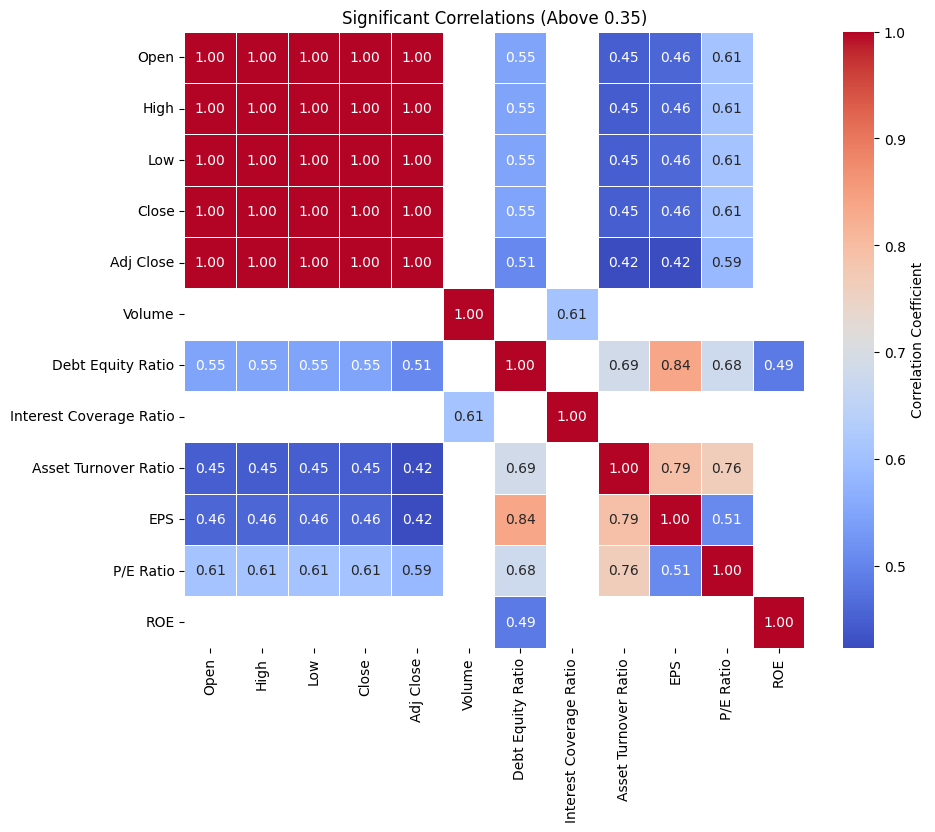

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns for correlation
numeric_columns = Master_df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix for numeric columns
correlation_matrix = numeric_columns.corr()

# Filter the correlation matrix to keep only values greater than 0.35
filtered_correlation_matrix = correlation_matrix.where(correlation_matrix > 0.35, other=None)

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Generate the heatmap with filtered correlations
sns.heatmap(filtered_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})

# Display the heatmap
plt.title('Significant Correlations (Above 0.35)')
plt.show()


In [6]:
import pandas as pd
df_encoded = pd.get_dummies(Master_df, columns=['Sector'], drop_first=True)
sector_columns = [col for col in df_encoded.columns if col.startswith('Sector_')]
sector_correlation_matrix = df_encoded[sector_columns].corr()
print("Correlation matrix between all sectors:")
sector_correlation_matrix


Correlation matrix between all sectors:


,Sector_Consumer Staples,Sector_Financials,Sector_Health Care,Sector_Information Technology
Sector_Consumer Staples,1.0,-0.2,-0.2,-0.2
Sector_Financials,-0.2,1.0,-0.2,-0.2
Sector_Health Care,-0.2,-0.2,1.0,-0.2
Sector_Information Technology,-0.2,-0.2,-0.2,1.0


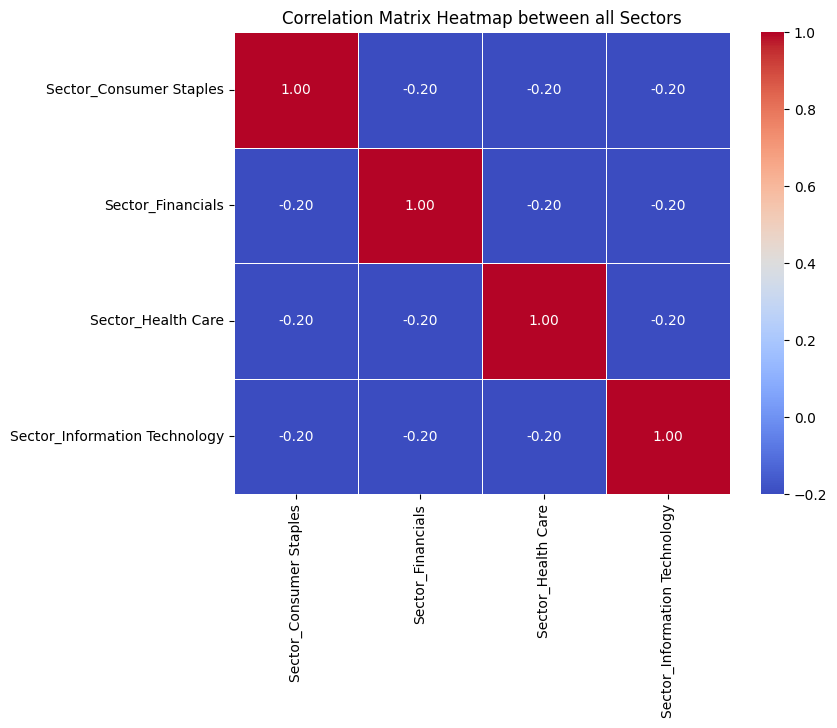

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Generate the heatmap
sns.heatmap(sector_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Display the heatmap
plt.title('Correlation Matrix Heatmap between all Sectors')
plt.show()


In [8]:
Master_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Company Name,Sector,Debt Equity Ratio,Interest Coverage Ratio,Asset Turnover Ratio,EPS,P/E Ratio,ROE
0,2014-12-11,47.080002,47.740002,46.680000,47.169998,40.504547,29060400.0,MSFT,Microsoft,Information Technology,0.907661,37.724702,0.478602,11.854394,37.418192,0.328281
1,2014-12-12,46.779999,47.730000,46.669998,46.950001,40.315624,34248400.0,MSFT,Microsoft,Information Technology,0.907661,37.724702,0.478602,11.854394,37.418192,0.328281
2,2014-12-15,47.200001,47.669998,46.549999,46.669998,40.075199,29247800.0,MSFT,Microsoft,Information Technology,0.907661,37.724702,0.478602,11.854394,37.418192,0.328281
3,2014-12-16,45.900002,46.340000,45.130001,45.160000,38.778557,47801400.0,MSFT,Microsoft,Information Technology,0.907661,37.724702,0.478602,11.854394,37.418192,0.328281
4,2014-12-17,45.049999,45.950001,44.900002,45.740002,39.276615,34970900.0,MSFT,Microsoft,Information Technology,0.907661,37.724702,0.478602,11.854394,37.418192,0.328281


In [10]:
Master_df.shape

(15084, 16)

In [12]:
price_data = Master_df.pivot(index='Date', columns='Ticker', values='Adj Close')

In [13]:
daily_returns = price_data.pct_change().dropna()

In [14]:
mean_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()

In [18]:
mean_returns

,0
Ticker,
COST,0.000952
FDS,0.000663
GOOG,0.000918
GOOGL,0.000909
JNJ,0.000308
MSFT,0.001099


In [17]:
cov_matrix

Ticker,COST,FDS,GOOG,GOOGL,JNJ,MSFT
Ticker,,,,,,
COST,0.000185,0.000096,0.000105,0.000106,0.000059,0.000119
FDS,0.000096,0.000249,0.000120,0.000120,0.000073,0.000139
GOOG,0.000105,0.000120,0.000320,0.000318,0.000064,0.000219
GOOGL,0.000106,0.000120,0.000318,0.000319,0.000064,0.000219
JNJ,0.000059,0.000073,0.000064,0.000064,0.000130,0.000075
MSFT,0.000119,0.000139,0.000219,0.000219,0.000075,0.000293


In [19]:
num_stocks = len(mean_returns)

In [33]:
from scipy.optimize import minimize
def portfolio_optimization(mean_returns, cov_matrix, target_return, risk_free_rate=0.01):
    def portfolio_performance(weights):
        returns = np.dot(weights, mean_returns)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe_ratio = (returns - risk_free_rate) / volatility
        return returns, volatility, sharpe_ratio

    def objective_function(weights):
        return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  # Minimize risk

    # Constraints and bounds
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Weights sum to 1
        {'type': 'ineq', 'fun': lambda x: np.dot(x, mean_returns) - target_return}  # Return >= target_return
    )
    bounds = tuple((0.01, 1) for _ in range(num_stocks))  # No zero weights

    # Initial guess
    initial_weights = np.ones(num_stocks) / num_stocks

    # Optimization
    result = minimize(objective_function, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

    # Optimal weights
    optimal_weights = result.x
    portfolio_return, portfolio_volatility, portfolio_sharpe = portfolio_performance(optimal_weights)

    return optimal_weights, portfolio_return, portfolio_volatility, portfolio_sharpe

In [34]:
target_annual_return = 0.09 / 252  # Convert annual return to daily (assuming 252 trading days)
optimal_weights, portfolio_return, portfolio_volatility, portfolio_sharpe = portfolio_optimization(
    mean_returns, cov_matrix, target_annual_return
)

In [35]:
allocation = pd.DataFrame({'Ticker': mean_returns.index, 'Weight': optimal_weights})
allocation['Weight'] = allocation['Weight'].round(4)

In [36]:
initial_investment = 40000  # Total investment amount in dollars
allocation['Investment Amount ($)'] = allocation['Weight'] * initial_investment

In [37]:
allocation

,Ticker,Weight,Investment Amount ($)
0,COST,0.2821,11284.0
1,FDS,0.0892,3568.0
2,GOOG,0.0358,1432.0
3,GOOGL,0.0338,1352.0
4,JNJ,0.5490,21960.0
5,MSFT,0.0100,400.0


In [38]:
print(f"\nExpected Portfolio Return: {portfolio_return:.4f}")
print(f"Expected Portfolio Volatility: {portfolio_volatility:.4f}")
print(f"Portfolio Sharpe Ratio: {portfolio_sharpe:.4f}")


Expected Portfolio Return: 0.0006
Expected Portfolio Volatility: 0.0100
Portfolio Sharpe Ratio: -0.9425


In [40]:
def project_portfolio_growth(initial_investment, weights, mean_returns, years=5):
    # Convert daily mean returns to annual mean returns (assuming 252 trading days)
    annual_mean_returns = mean_returns * 252

    # Calculate the weighted annual return of the portfolio
    annual_portfolio_return = np.dot(weights, annual_mean_returns)

    # Calculate the portfolio value over the specified years
    future_value = initial_investment * ((1 + annual_portfolio_return) ** years)

    return future_value, annual_portfolio_return

# Step 10: Perform the projection
future_portfolio_value, annual_return = project_portfolio_growth(
    initial_investment=40000,
    weights=optimal_weights,
    mean_returns=mean_returns,
    years=5
)

# Step 11: Display the results
print(f"Projected Portfolio Value after 5 Years: ${future_portfolio_value:,.2f}")
print(f"Assumed Annual Portfolio Return: {annual_return:.4%}")


Projected Portfolio Value after 5 Years: $78,403.96
Assumed Annual Portfolio Return: 14.4078%


[*********************100%***********************]  1 of 1 completed


Price        Adj Close       Close        High         Low        Open  \
Ticker             VOO         VOO         VOO         VOO         VOO   
Date                                                                     
2020-01-02  276.999207  298.420013  298.450012  296.339996  297.290009   
2020-01-03  274.975647  296.239990  297.359985  295.040009  295.220001   
2020-01-06  276.006073  297.350006  297.420013  294.350006  294.420013   
2020-01-07  275.244904  296.529999  297.269989  296.059998  296.820007   
2020-01-08  276.665100  298.059998  299.309998  296.470001  296.709991   

Price        Volume  
Ticker          VOO  
Date                 
2020-01-02  3142400  
2020-01-03  3247900  
2020-01-06  2777100  
2020-01-07  2251800  
2020-01-08  3719500  
Annualized Volatility: 0.2140


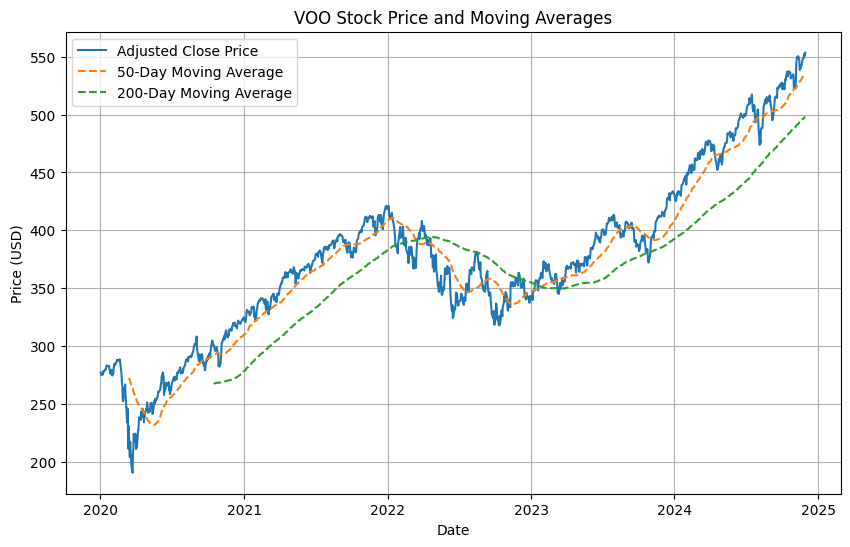

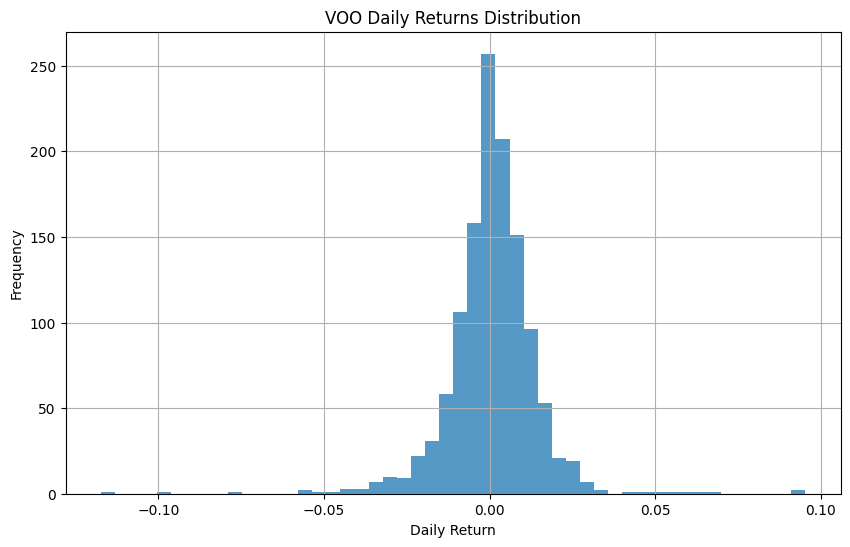

In [41]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Download historical stock data for Vanguard ETF (e.g., VOO)
ticker = 'VOO'  # Vanguard S&P 500 ETF
start_date = '2020-01-01'
end_date = '2024-12-01'
data = yf.download(ticker, start=start_date, end=end_date)

# Display basic information about the dataset
print(data.head())

# Calculate daily returns
data['Daily Return'] = data['Adj Close'].pct_change()

# Calculate moving averages (50-day and 200-day)
data['50-Day MA'] = data['Adj Close'].rolling(window=50).mean()
data['200-Day MA'] = data['Adj Close'].rolling(window=200).mean()

# Calculate volatility (standard deviation of daily returns)
volatility = data['Daily Return'].std() * (252 ** 0.5)  # Annualized volatility
print(f"Annualized Volatility: {volatility:.4f}")

# Plot Adjusted Close Price and Moving Averages
plt.figure(figsize=(10, 6))
plt.plot(data['Adj Close'], label='Adjusted Close Price')
plt.plot(data['50-Day MA'], label='50-Day Moving Average', linestyle='--')
plt.plot(data['200-Day MA'], label='200-Day Moving Average', linestyle='--')
plt.title(f"{ticker} Stock Price and Moving Averages")
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Plot daily returns
plt.figure(figsize=(10, 6))
data['Daily Return'].plot(kind='hist', bins=50, alpha=0.75)
plt.title(f"{ticker} Daily Returns Distribution")
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
